# KTP Waveguide dispersion

This example shows how to sweep the dispersion of a generic waveguide. To do this we need to feed the solver some dispersion as a function of 
 $\lambda$ using smelmers equation. 
 
The constants for the equation can be found here:
http://www.unitedcrystals.com/KTPProp.html

Remember KTP has a different refractive index for each axis which needs to be passed to the solver.

In [38]:
def refractive(lam):
    
    n_square = [ 3.0065 + 0.03901 / (lam**2 - 0.04251) - 0.01327 * lam**2 , 
                 3.0333 + 0.04154 / (lam**2 - 0.04547) - 0.01408 * lam**2 , 
                 3.0065 + 0.05694 / (lam**2 - 0.05658) - 0.01682 * lam**2   ]
    
    index = [ns**0.5 for ns in n_square]
    return index

To build the geometry you can use your choice of graphics library (or just brute force it): this example uses pillow.   


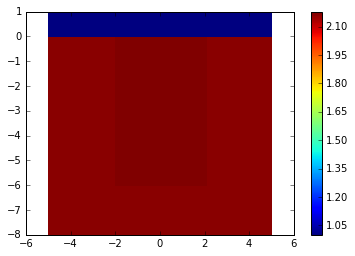

In [63]:
%matplotlib inline

import philsol as ps
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cst
from matplotlib import cm 
from PIL import Image, ImageDraw


# We define the size of the simulation window (note there is automatically a conductive boundry layer).
simulation_width = 10.
simulation_height = 9. 

# Number of pixels/fd grid points. 
num_x = 81
num_y = 101
dx = simulation_width / float(num_x - 1)
dy = simulation_height / float(num_y - 1)

# Wavelength of end point
lam = .3
k = 2 * cst.pi / lam 

# We deffine some parameters of the waveguide(refer to the plot if confused!)
air_height = 1. 
WG_height = 6.
WG_width = 4.

#...lets build a geometry...#
# note: using pillow might seem a bit convoluted but for more complex geometries it saves a lot of pain
def n_build(lam):    
    # we start with a KTP slab
    n_ax = refractive(lam)
    n_ax = [n_ax[1], n_ax[2], n_ax[0]]
    geom = [Image.new('F', (num_x, num_y), n_ax[i]) for i in range(3)]
    geom_draw = [ImageDraw.Draw(axis) for axis in geom]

    # now we need some air
    air_index = int(round((simulation_height - air_height) / dy))  
    [ axis.rectangle([0, air_index, num_x - 1, num_y - 1], 1.) 
       for axis in geom_draw ]

    # Now we draw the waveguide with a slightly larger intex
    x0_ind = int(round((simulation_width - WG_width) / (2. * dx)))
    x1_ind = int(round((simulation_width + WG_width) / (2. * dx)))
    y0_ind = int(round((simulation_height - air_height - WG_height) / dy )) 
    y1_ind = air_index - 1

    [geom_draw[i].rectangle([x0_ind, y0_ind, x1_ind, y1_ind], n_ax[i] + 0.01)  
       for i in range(3) ]
    
    #Now we assemble a matrix we can give to the solver 
    n =  np.dstack( 
           [np.asarray(axis.getdata(), dtype = np.float64).reshape((num_y, num_x))
              for axis in geom]
                  )
    return n

x = np.linspace(-simulation_width / 2., simulation_width / 2., num_x)
y = np.linspace(air_height - simulation_height, air_height, num_y)
n = n_build(lam)

plt.pcolor(x,y,n[:,:,1])
#n = np.moveaxis(n,[1,2,3], [2,1,3])
plt.colorbar()




In [58]:
#n = np.ones((num_x, num_y, 3))
#n[19:49, 19:49, :] = n[19:49, 19:49, :] + 0.45
print(refractive(lam))

P, _ = ps.eigen_build(k, n, dy, dx)
neff = 2.5
neigs = 10
beta_in = 2. * cst.pi * neff / lam 

beta, Ex, Ey = ps.solve.solve(P, beta_in, neigs = neigs)

print(np.shape(Ey))
Ex_plot = np.reshape(Ex, (num_x, num_y, neigs))
Ey_plot = np.reshape(Ey, (num_x, num_y, neigs))

[1.95620596865688, 1.9912024145119076, 2.1699669116109894]
Assembling matrix for 8181 grid points...

and we are done (after 0.0199999809265 secs).
Solving eigenmodes on CPU
6.03399991989 secs later we have the final solution.
(8181L, 10L)


Now we can plot these modes. Since the refractive index is bigger on the y axis these modes will have higher index we can plot these out. 

Effective Index = 2.17954368571


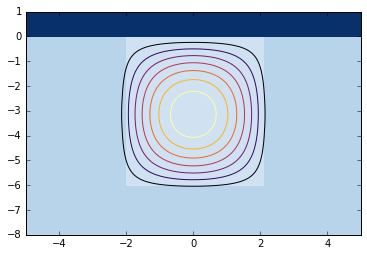

Effective Index = 2.17915599831


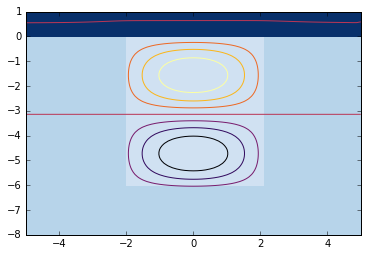

Effective Index = 2.17866755051


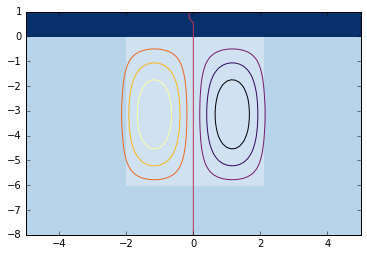

Effective Index = 2.17851136397


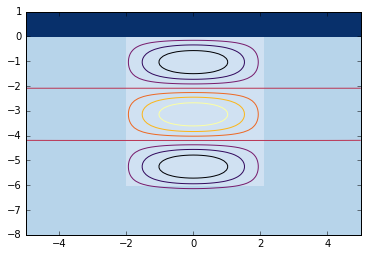

Effective Index = 2.17827997053


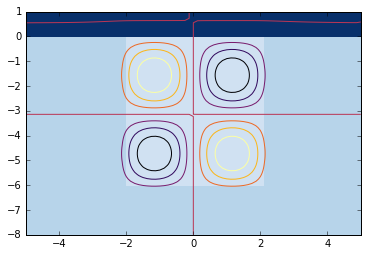

Effective Index = 2.17761221314


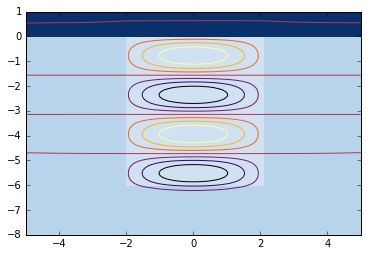

Effective Index = 2.17763554037


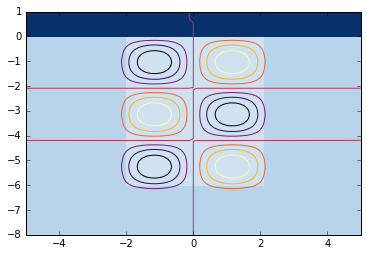

Effective Index = 2.17722678833


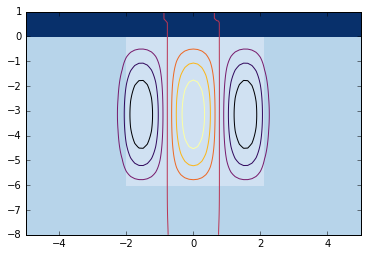

Effective Index = 2.17683944786


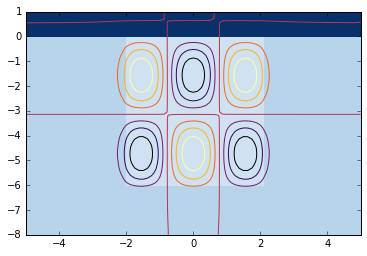

Effective Index = 2.17673674051


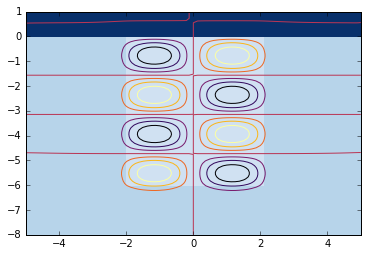

In [59]:

for i in range(neigs):
    plt.figure()
    print('Effective Index = {}'.format(abs(beta[i] * lam / (2*cst.pi))))
    plt.pcolor(x,y,n[:,:,1], cmap = cm.Blues_r)
    plt.clim([2.1, 2.2])
    #plt.colorbar()
    plt.contour(x,y, np.transpose(Ey_plot[:,:,i].real), cmap = cm.inferno)
    plt.show()

Ok now we can pick a mode and sweep it over some range. This is a problem because the solver (like most solvers) requires a good guess for beta. To get round this we can run the above code for the wavelengths at either end of our range and fit a simple function such as and exponential to it. It might be nessary to solve for more modes than we need and post process the result. Let solve for the dispersion over the range $0.3\mu m$ to $1.\mu m$   


In [62]:
def n_guide(lam):
    A = 2.17954368571 
    B = np.log(2.17954368571 / 1.75292972992) / 0.7
    return A * np.exp(- B * (lam - 0.3))

steps = 20
neigs = 5
lam = np.linspace(0.3, 1., steps)
n_trial = n_guide(lam)

#Hopefully we can give it a bit more gas by passing a trial field 
E_in = np.concatenate((Ex[:,0], Ey[:,0]))
    
# Now we have a go sweeping 
betaEy_out = []
Ey_plot = []
Ex_plot = []
for i in range(steps):
    n = n_build(lam[i])
    k = 2. * cst.pi / lam[i] 
    P, _ = ps.eigen_build(k, n, dy, dx)
    
    beta, Ex , Ey = ps.solve.solve(   P, 
                                      2. * n_trial[i] * cst.pi / lam[i], 
                                      #E_trial = E_in,  
                                      neigs = neigs  )
    
    Ey_plot.append(np.reshape(Ey, (num_x, num_y, neigs)))
    Ex_plot.append(np.reshape(Ey, (num_x, num_y, neigs)))
    betaEy_out.append(beta)


Assembling matrix for 8181 grid points...

and we are done (after 0.0250000953674 secs).


TypeError: solve() takes at least 2 arguments (3 given)

Ok so some of the modes will have changed position during the run so we need to do some post processing to keep track of the index of the mode we are interested in.

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0


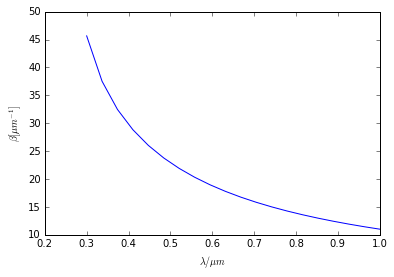

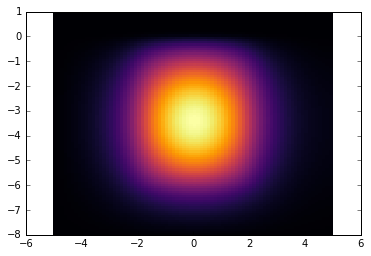

In [24]:
index = 0
betaEy_trace = [betaEy_out[0][index]]
Ey_plot_trace = [Ey_plot[0][:,:,index]]
Ex_plot_trace = [Ex_plot[0][:,:,index]]
for i in range(steps-1):
    # Takes product of all modes with all next modes the largest value should be the same mode!    
    prod_next = abs(np.einsum('ijk, ijl', Ey_plot[i], Ey_plot[i + 1]))
    index = np.argmax(prod_next[index, :])
    print(index)
    betaEy_trace.append(betaEy_out[i+1][index])
    Ey_plot_trace.append(Ey_plot[i+1][:,:,index])
    Ex_plot_trace.append(Ex_plot[i+1][:,:,index])
    
# Now we can plot the dispersion and e field
plt.figure()
plt.plot(lam, betaEy_trace)
plt.xlabel('$\lambda / \mu m$')
plt.ylabel(r'$\beta [ \mu m^{-1} ]$')
plt.plot()
plt.show()

 
plt.figure()
some_random_point = 18
xend = np.size(x)
yend = np.size(y)
plt.pcolor(x, y, np.transpose(Ey_plot_trace[some_random_point][:,:]), cmap = cm.inferno)
plt.show()

In [25]:
# Now you can save your data if you feel so inclined

import pickle 
from time import strftime

strftime("%d%b%Y_%H%M")
Array_pack = {
    'Ex_polar': [betaEx_trace, Ex_plot_trace], 
    'Ey_polar': [betaEy_trace, Ey_plot_trace],
    'width'   : WG_width,
    'height'  : WG_height,
    'Lambda'  : lam   }


pickle.dump(Array_pack, open('KTP_dispersion_' +strftime("%d%b%Y_%H%M") + '.p', 'wb'))

SyntaxError: invalid syntax (<ipython-input-25-8fdfd484a06f>, line 13)